In [31]:
# Imports des bibliothèques nécessaires
import numpy as np
import pandas as pd
import os
import shutil

# TensorFlow et Keras
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.preprocessing import image_dataset_from_directory

# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score



In [4]:
# Configuration du système
seed = 1
batch_size = 32
image_size = (128, 128)
epochs = 10
selected_user = "oliwer"

In [5]:
# Configuration utilisateur et préparation du dataset

def setup_binary_dataset():
    """Configure le dataset binaire pour la reconnaissance de Damien"""
    # Dossiers source et destination
    processed_dir = './processed/' + selected_user
    binary_dataset_dir = './binary_dataset'
    user_dir = os.path.join(binary_dataset_dir, 'user')
    others_dir = os.path.join(binary_dataset_dir, 'others')
    
    # Créer les dossiers si nécessaire
    os.makedirs(user_dir, exist_ok=True)
    os.makedirs(others_dir, exist_ok=True)
    
    # Nettoyer le dossier user actuel
    for file in os.listdir(user_dir):
        file_path = os.path.join(user_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    # Copier les photos
    copied_count = 0
    for folder in ['train', 'test']:
        source_folder = os.path.join(processed_dir, folder)
        if os.path.exists(source_folder):
            photos = [f for f in os.listdir(source_folder) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for photo in photos:
                src = os.path.join(source_folder, photo)
                dst = os.path.join(user_dir, f"{folder}_{photo}")
                try:
                    shutil.copy2(src, dst)
                    copied_count += 1
                except Exception as e:
                    print(f"Erreur {photo}: {e}")
    
    # Statistiques
    user_count = len([f for f in os.listdir(user_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    others_count = len([f for f in os.listdir(others_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    print(f"Dataset configuré:")
    print(f"   Photos de {selected_user}: {user_count}")
    print(f"   Photos d'autres: {others_count}")
    
    return user_count > 0 and others_count > 0

dataset_ready = setup_binary_dataset()

if dataset_ready:
    print(f"Système configuré pour: {selected_user}")
else:
    print("Problème de configuration du dataset")

Dataset configuré:
   Photos de oliwer: 300
   Photos d'autres: 900
Système configuré pour: oliwer


In [ ]:
# Chargement du dataset pour classification binaire

def load_binary_dataset():
    binary_data_dir = './binary_dataset' # Dossier contenant les images
    
    # Vérifier l'existence du dossier
    if not os.path.exists(binary_data_dir):
        print("Dossier binary_dataset non trouvé!")
        return None, None
    
    # Vérifier la présence d'images
    user_dir = os.path.join(binary_data_dir, 'user') # Dossier pour les images de l'utilisateur
    others_dir = os.path.join(binary_data_dir, 'others') # Dossier pour les images des autres
    
    user_photos = len([f for f in os.listdir(user_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(user_dir) else 0
    others_photos = len([f for f in os.listdir(others_dir) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(others_dir) else 0
    
    if user_photos == 0 or others_photos == 0:
        print(f"Dataset incomplet: USER={user_photos}, OTHERS={others_photos}")
        return None, None
    
    try:
        print("Chargement du dataset avec normalisation correcte...")

        # Créer les datasets d'entraînement et de validation    
        train_ds = image_dataset_from_directory(
            binary_data_dir,
            validation_split=0.2,
            subset='training',
            seed=seed,
            label_mode='binary',
            batch_size=batch_size,
            image_size=image_size
        )
    
        validation_ds = image_dataset_from_directory(
            binary_data_dir,
            validation_split=0.2,
            subset='validation',
            seed=seed,
            label_mode='binary',
            batch_size=batch_size,
            image_size=image_size
        )
        
        # Récupérer les noms de classes
        class_names = train_ds.class_names
        
        # Normalisation des images
        def normalize_and_verify(image, label):
            image = tf.cast(image, tf.float32) / 255.0
            tf.debugging.assert_all_finite(image, "Image contient des valeurs non-finies")
            tf.debugging.assert_greater_equal(image, 0.0, "Image contient des valeurs négatives")
            tf.debugging.assert_less_equal(image, 1.0, "Image contient des valeurs > 1")
            
            return image, label
        
        # Appliquer la normalisation
        train_ds = train_ds.map(normalize_and_verify, num_parallel_calls=tf.data.AUTOTUNE)
        validation_ds = validation_ds.map(normalize_and_verify, num_parallel_calls=tf.data.AUTOTUNE)
        
        # Optimisation des performances
        train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
        validation_ds = validation_ds.cache().prefetch(tf.data.AUTOTUNE)
        
        print(f"Dataset chargé avec succès")
        print(f"   Classes: {class_names}")
        print(f"   Distribution: USER={user_photos}, OTHERS={others_photos}")
    
        return train_ds, validation_ds
    
    except Exception as e:
        print(f"Erreur lors du chargement: {e}")
        return None, None

# Chargement automatique
train_ds, validation_ds = load_binary_dataset()

Chargement du dataset avec normalisation correcte...
Found 1200 files belonging to 2 classes.
Using 960 files for training.
Found 1200 files belonging to 2 classes.
Using 240 files for validation.
Dataset chargé avec succès
   Classes: ['others', 'user']
   Distribution: USER=300, OTHERS=900


In [13]:
# Création du modèle 

def create_model():
    print("Création du modèle amélioré...")

    model = Sequential([
        # Première couche Conv avec initialisation he_normal
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*image_size, 3), kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        # Deuxième couche Conv
        Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        # Troisième couche Conv
        Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        # Couches denses avec dropout réduit
        Flatten(),

        # Première couche Dense avec initialisation he_normal
        Dense(256, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.3),
        
        # Deuxième couche Dense
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        
        # Couche de sortie
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Compilation avec optimiseur Adam optimisé
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    print("Modèle amélioré créé et compilé")
    model.summary()
    
    return model

In [14]:
# Test du modèle amélioré
def test_model(model_to_test):
    print("\nTest du modèle:")
    print("-" * 50)
    
    # Tester sur les images users
    user_dir = './binary_dataset/user'
    if os.path.exists(user_dir):
        user_images = [f for f in os.listdir(user_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
        
        for img_file in user_images:
            img_path = os.path.join(user_dir, img_file)
            
            # Preprocessing identique à l'entraînement
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalisation identique
            img_array = np.expand_dims(img_array, axis=0)
            
            # Prédiction
            pred = model_to_test.predict(img_array, verbose=0)[0][0]
            status = "DAMIEN" if pred >= 0.5 else "AUTRE"
            print(f"   {img_file}: {pred:.4f} {status}")
    
        # Tester sur les images des autres
        others_dir = './binary_dataset/others'
        if os.path.exists(others_dir):
            others_images = [f for f in os.listdir(others_dir) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
            
            for img_file in others_images:
                img_path = os.path.join(others_dir, img_file)
                
                # Preprocessing
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                
                # Prédiction
                pred = model_to_test.predict(img_array, verbose=0)[0][0]
                status = "AUTRE" if pred < 0.5 else "DAMIEN"
                print(f"   {img_file}: {pred:.4f} {status}")

print("Fonctions de modèle créées")

Fonctions de modèle créées


In [ ]:
# Vérifier que le dataset est chargé
if train_ds is None or validation_ds is None:
    print("Dataset non disponible. Rechargement...")
    train_ds, validation_ds = load_binary_dataset()

if train_ds is None:
    print("Impossible de charger le dataset")
else:
    print("Démarrage de l'entraînement...")
    
    # Créer le modèle amélioré
    model = create_model() # Création du modèle amélioré
    
    # Configuration des callbacks
    checkpoint_path = f"./models/model_{selected_user}.keras" # Chemin de sauvegarde du modèle
    os.makedirs("./models", exist_ok=True)
    
    callbacks = [
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True),
    ]

    print(f"Modèle sera sauvegardé: {checkpoint_path}")
    
    # Entraînement
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        callbacks=callbacks,
        verbose=1
    )
    
    # Test du nouveau modèle
    print("\nTest du modèle:")
    test_model(model)
    
    # Affichage des résultats finaux
    if history:
        final_acc = history.history['val_accuracy'][-1]
        final_loss = history.history['val_loss'][-1]
        
        print(f"\nRÉSULTATS FINAUX:")
        print(f"Précision validation: {final_acc:.2%}")
        print(f"Perte validation: {final_loss:.4f}")
        

Démarrage de l'entraînement...
Création du modèle amélioré...
Modèle amélioré créé et compilé


c:\Users\Oliwer\Documents\facial_recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,516,033 (32.49 MB)

 Trainable params: 8,515,585 (32.48 MB)

 Non-trainable params: 448 (1.75 KB)

Modèle sera sauvegardé: ./models/fixed_model_oliwer.keras
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8778 - loss: 0.8654 - precision: 0.7701 - recall: 0.8349
Epoch 1: val_accuracy improved from None to 0.83750, saving model to ./models/fixed_model_oliwer.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9563 - loss: 0.4191 - precision: 0.9004 - recall: 0.9300 - val_accuracy: 0.8375 - val_loss: 2.0249 - val_precision: 1.0000 - val_recall: 0.3158 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9939 - loss: 0.0264 - precision: 0.9939 - recall: 0.9840
Epoch 2: val_accuracy improved from 0.83750 to 0.85000, saving model to ./models/fixed_model_oliwer.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.9958 - loss: 0.0358 - precision: 0.9918 - recall: 0.9918 - val_accuracy: 0.8500 - val_loss: 0.9723 - val_precision: 1.0000 - val_recall: 0.3684 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

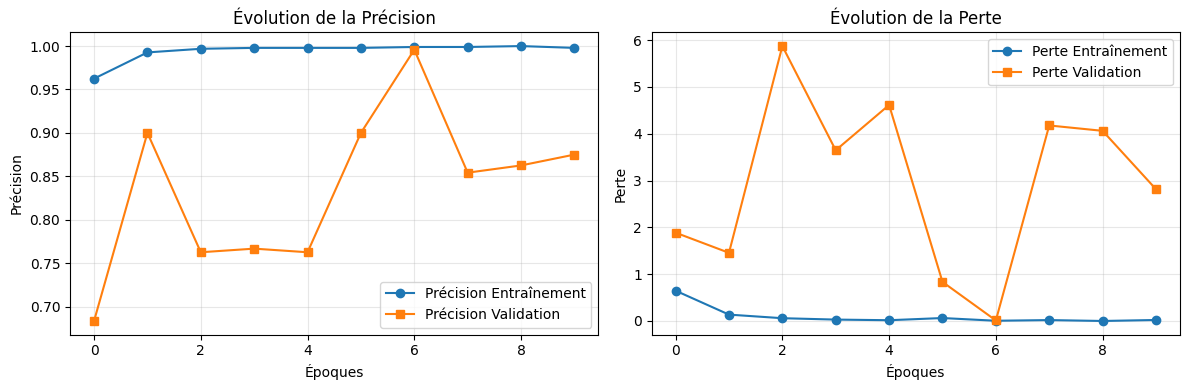

In [17]:
# Visualisation des résultats d'entraînement
if 'history_fixed' in globals() and history_fixed is not None:
    plt.figure(figsize=(12, 4))
    
    # Graphique de précision
    plt.subplot(1, 2, 1)
    plt.plot(history_fixed.history['accuracy'], label='Précision Entraînement', marker='o')
    plt.plot(history_fixed.history['val_accuracy'], label='Précision Validation', marker='s')
    plt.title('Évolution de la Précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Graphique de perte
    plt.subplot(1, 2, 2)
    plt.plot(history_fixed.history['loss'], label='Perte Entraînement', marker='o')
    plt.plot(history_fixed.history['val_loss'], label='Perte Validation', marker='s')
    plt.title('Évolution de la Perte')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des métriques finales
    final_train_acc = history_fixed.history['accuracy'][-1]
    final_val_acc = history_fixed.history['val_accuracy'][-1]
    final_train_loss = history_fixed.history['loss'][-1]
    final_val_loss = history_fixed.history['val_loss'][-1]
    
else:
    print("Aucun historique d'entraînement disponible")
    print("Exécutez d'abord la cellule d'entraînement corrigé")

In [25]:
# Fonctions de test final
def load_model():

    model_path = f"./models/model_{selected_user}.keras"
    
    global model
    
    if os.path.exists(model_path):
        try:
            model = tf.keras.models.load_model(model_path)
            print(f"Modèle corrigé chargé: {model_path}")
            print(f"Configuré pour: {selected_user}")
            return model
        except Exception as e:
            print(f"Erreur chargement modèle corrigé: {e}")
    
    print(f"Aucun modèle trouvé!")
    print(f"Exécutez d'abord l'entraînement ou le réentraînement corrigé")
    model = None
    return None

In [26]:
# Préprocessing des images

def preprocess_final_image(image_path):
    try:
        # Charger l'image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        
        # Convertir en array
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Normalisation IDENTIQUE à l'entraînement
        img_array = img_array / 255.0
        
        # Ajouter dimension batch
        img_array = np.expand_dims(img_array, axis=0)
        
        return img_array
    except Exception as e:
        print(f"Erreur preprocessing: {e}")
        return None

def predict_final(image_path, threshold=0.5):
    if 'model' not in globals() or model is None:
        print("Aucun modèle chargé")
        return None
    
    # Preprocessing
    img_array = preprocess_final_image(image_path)
    if img_array is None:
        return None
    
    # Prédiction
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Décision
    is_user = prediction >= threshold
    
    return {
        'image_path': image_path,
        'probability': float(prediction),
        'is_user': bool(is_user),
        'confidence': float(max(prediction, 1 - prediction)),
        'user_name': selected_user if is_user else 'autre',
        'decision': 1 if is_user else 0
    }

def test_single_image_final(image_path, threshold=0.5):
        
    if not os.path.exists(image_path):
        print(f"Image non trouvée: {image_path}")
        return None
    
    result = predict_final(image_path, threshold)
    if result:
        status = "DAMIEN DETECTE" if result['is_user'] else "AUTRE PERSONNE"
        
        print(f"Résultat: {status}")
        print(f"Probabilité: {result['probability']:.4f}")
        print(f"Confiance: {result['confidence']:.1%}")
        print(f"Seuil utilisé: {threshold}")
        
        # Suggestions de seuils
        print(f"\nTest avec différents seuils:")
        for t in [0.3, 0.5, 0.7, 0.9]:
            decision = "DAMIEN" if result['probability'] >= t else "AUTRE"
            correct = (result['probability'] >= t) == result['is_user']
            status_icon = "CORRECT" if correct else "DIFFERENT"
            print(f"   Seuil {t}: {status_icon} {decision}")
    
    return result

def test_multiple_images_final():
    print("\nTESTS AUTOMATIQUES:")
    print("=" * 60)
    
    # Test images USER
    user_dir = './binary_dataset/user'
    if os.path.exists(user_dir):
        user_images = [f for f in os.listdir(user_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
        
        print("Test images USER (doivent être détectées comme DAMIEN):")
        for img_file in user_images:
            img_path = os.path.join(user_dir, img_file)
            result = predict_final(img_path)
            if result:
                status = "CORRECT" if result['is_user'] else "ERREUR"
                print(f"   {img_file}: {result['probability']:.4f} → {status}")
    
    # Test images OTHERS
    others_dir = './binary_dataset/others'
    if os.path.exists(others_dir):
        others_images = [f for f in os.listdir(others_dir) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
        
        print("\nTest images OTHERS (doivent être détectées comme AUTRE):")
        for img_file in others_images:
            img_path = os.path.join(others_dir, img_file)
            result = predict_final(img_path)
            if result:
                status = "CORRECT" if not result['is_user'] else "ERREUR"
                print(f"   {img_file}: {result['probability']:.4f} → {status}")

print("Fonctions de test final créées")

Fonctions de test final créées


In [27]:
loaded_model = load_model()

if loaded_model:
    print(f"\nModèle chargé avec succès ({loaded_model})")
    test_multiple_images_final()
else:
    print("\nÉchec du chargement du modèle")
    print("Assurez-vous d'avoir exécuté l'entraînement corrigé")

Modèle corrigé chargé: ./models/model_oliwer.keras
Configuré pour: oliwer

Modèle chargé avec succès (<Sequential name=sequential_1, built=True>)

TESTS AUTOMATIQUES:
Test images USER (doivent être détectées comme DAMIEN):
   test_dark_20250731_114205_007.jpg: 1.0000 → CORRECT
   test_dark_20250731_114205_009.jpg: 1.0000 → CORRECT
   test_dark_20250731_114205_012.jpg: 1.0000 → CORRECT

Test images OTHERS (doivent être détectées comme AUTRE):
   Alessandra_Cerna_Alessandra_Cerna_0001.jpg: 0.0000 → CORRECT
   Alexander_Downer_Alexander_Downer_0002.jpg: 0.0000 → CORRECT
   Alexandra_Vodjanikova_Alexandra_Vodjanikova_0001.jpg: 0.0000 → CORRECT


In [28]:
test_photos_dir = './processed/test_photos'
os.makedirs(test_photos_dir, exist_ok=True)

if os.path.exists(test_photos_dir):
    photos = [f for f in os.listdir(test_photos_dir) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if photos:
        print(f"{len(photos)} photo(s) trouvée(s):")
        for photo in photos:
            print(f"   {photo}")
        
        print("\nPour tester une photo, utilisez:")
        print(f"test_single_image_final('{test_photos_dir}/{photos[0]}')")
    else:
        print("Aucune photo dans le dossier de test")
        print("Copiez vos photos dans ce dossier puis réexécutez cette cellule")
else:
    print("Impossible de créer le dossier de test")

test_single_image_final("./processed/test_photos/Média (2).jpg")

print("\nPrêt pour vos tests personnalisés!")

17 photo(s) trouvée(s):
   1Média (1).jpg
   1Média.jpg
   200px-Trevor.png
   Albert-Einstein.jpg
   image.png
   Média (2).jpg
   Média (3).jpg
   Média.jpg
   téléchargement (1).jpg
   téléchargement (2).jpg
   téléchargement (3).jpg
   téléchargement (4).jpg
   téléchargement.jpg
   téléchargement2.jpg
   untitled (1).png
   untitled@2x (2).png
   untitled@2x (3).png

Pour tester une photo, utilisez:
test_single_image_final('./processed/test_photos/1Média (1).jpg')
Résultat: AUTRE PERSONNE
Probabilité: 0.0000
Confiance: 100.0%
Seuil utilisé: 0.5

Test avec différents seuils:
   Seuil 0.3: CORRECT AUTRE
   Seuil 0.5: CORRECT AUTRE
   Seuil 0.7: CORRECT AUTRE
   Seuil 0.9: CORRECT AUTRE

Prêt pour vos tests personnalisés!


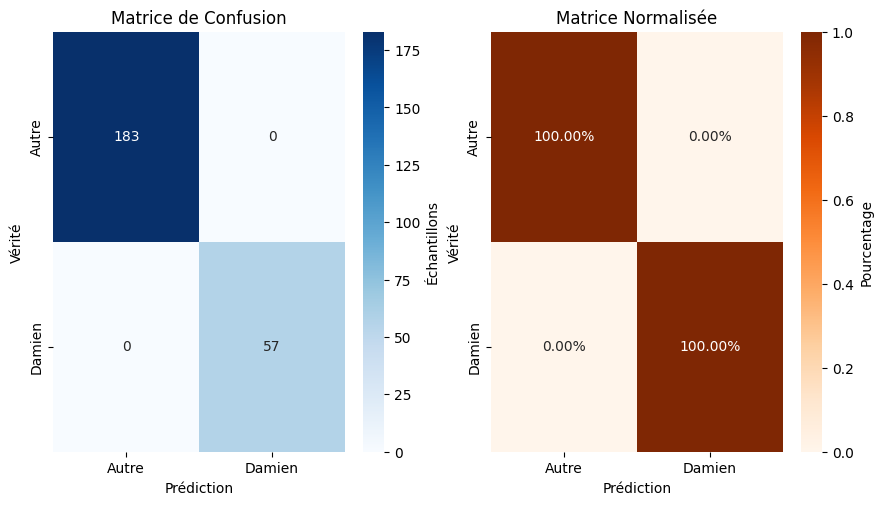

In [ ]:
# Test du Modèle - Version graphique uniquement

def evaluate_model_visual_only():
    
    if 'model' not in globals() or model is None:
        return
    if validation_ds is None:
        return
    
    # Extraction des données
    y_true = []
    y_pred_proba = []
    
    for batch_images, batch_labels in validation_ds:
        batch_predictions = model.predict(batch_images, verbose=0)
        y_true.extend(batch_labels.numpy().flatten())
        y_pred_proba.extend(batch_predictions.flatten())
    
    # Conversion en arrays
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcul des métriques
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Classes
    class_names = ['Autre', 'Damien']
    
    plt.figure(figsize=(16, 12))
    
    # Matrice de confusion
    plt.subplot(2, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Échantillons'})
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    
    # Matrice de confusion normalisée
    plt.subplot(2, 3, 2)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Pourcentage'})
    plt.title('Matrice Normalisée')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')

# Exécution
results = evaluate_model_visual_only()